**Load Local US Covid Dataset**

In [1]:
storagePath = "abfss://churning@churninge2edemo.dfs.core.windows.net/synapse/tables/covid"
dfLocalDataset = spark.read.load(f"{storagePath}/delta/us", format="delta")


StatementMeta(smallPool, 30, 1, Finished, Available)

StatementMeta(smallPool, 30, 2, Finished, Available)

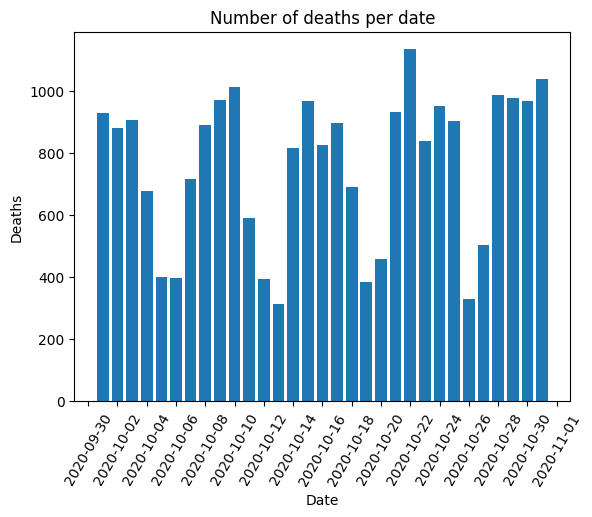


/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.ticker as ticker

dfLocalDatasetPd = dfLocalDataset.toPandas()
ax = plt.subplot(111)
ax.bar(dfLocalDatasetPd['date_rep'],dfLocalDatasetPd['deaths'])
ax.xaxis_date()
tick_spacing = 2

ax.set_ylabel("Deaths")
ax.set_xlabel("Date")
ax.set_title("Number of deaths per date")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=60)
plt.show()

**Load updated covid dataset**

In [3]:
# Azure storage access info
blob_account_name = "pandemicdatalake"
blob_container_name = "public"
blob_relative_path = "curated/covid-19/ecdc_cases/latest/ecdc_cases.parquet"
blob_sas_token = r""

# Allow SPARK to read from Blob remotely
wasbs_path = 'wasbs://%s@%s.blob.core.windows.net/%s' % (blob_container_name, blob_account_name, blob_relative_path)
spark.conf.set(
  'fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name),
  blob_sas_token)
print('Remote blob path: ' + wasbs_path)

# SPARK read parquet, note that it won't load any data yet by now
# Taking only US records
dfUpdatedDataset = spark.read.parquet(wasbs_path).where("iso_country = 'US' and date_rep >= '2020-10-01'")

StatementMeta(smallPool, 30, 3, Finished, Available)

Remote blob path: wasbs://public@pandemicdatalake.blob.core.windows.net/curated/covid-19/ecdc_cases/latest/ecdc_cases.parquet

**Merge local and updated dataset**

In [4]:
from delta.tables import *

deltaUsCovidTable = DeltaTable.forPath(spark,f"{storagePath}/delta/us")

deltaUsCovidTable.alias("deltaLake").merge(dfUpdatedDataset.alias("dataUpdate"),condition="deltaLake.date_rep = dataUpdate.date_rep and deltaLake.iso_country = dataUpdate.iso_country").whenNotMatchedInsert(values =
    {
      "date_rep": "dataUpdate.date_rep",
      "deaths": "dataUpdate.deaths"
    }
  ) \
  .execute()


StatementMeta(smallPool, 30, 4, Finished, Available)

StatementMeta(smallPool, 30, 9, Finished, Available)

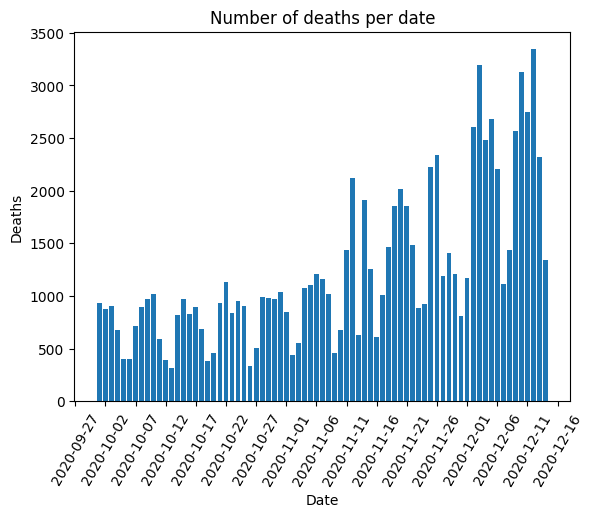

In [9]:
dfLocalDatasetUpdatedPd = deltaUsCovidTable.toDF().toPandas()
ax = plt.subplot(111)
ax.bar(dfLocalDatasetUpdatedPd['date_rep'],dfLocalDatasetUpdatedPd['deaths'])
ax.xaxis_date()
tick_spacing = 5

ax.set_ylabel("Deaths")
ax.set_xlabel("Date")
ax.set_title("Number of deaths per date")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=60)
plt.show()